In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [1]:
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

orders = ['Hours', 'Capillary refill rate', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glascow coma scale eye opening',
       'Glascow coma scale motor response', 'Glascow coma scale total',
       'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH']

count = pd.read_csv('../mimic3-benchmarks/mimic3benchmark/resources/variable_ranges.csv', sep=',')
limit = []
cat_name = ["Glascow coma scale eye opening",
"Glascow coma scale motor response",
#"Glascow coma scale total",
"Glascow coma scale verbal response"]
for col in orders:
    if len(count[(count['LEVEL2']==col)])==1 and col not in cat_name:
        x = float(count[(count['LEVEL2']==col)]['OUTLIER LOW'])
        y = float(count[(count['LEVEL2']==col)]['OUTLIER HIGH'])
        limit.append((col, x, y))
        print(col, x, y)

refine_eye = {
     "None": "None",
     "1 No Response": "1 No Response",
     "2 To pain": "To Pain", 
     "To Pain": "To Pain",
     "3 To speech": "To Speech", 
     "To Speech": "To Speech",
     "4 Spontaneously": "Spontaneously",
     "Spontaneously": "Spontaneously"
}
refine_motor = {
    "1 No Response": "No response",
    "No response": "No response",
    "2 Abnorm extensn": "Abnormal extension",
    "Abnormal extension": "Abnormal extension",
    "3 Abnorm flexion": "Abnormal Flexion",
    "Abnormal Flexion": "Abnormal Flexion",
    "4 Flex-withdraws": "Flex-withdraws",
    "Flex-withdraws": "Flex-withdraws",
    "5 Localizes Pain": "Localizes Pain",
    "Localizes Pain": "Localizes Pain",
    "6 Obeys Commands": "Obeys Commands",
    "Obeys Commands": "Obeys Commands"
}
refine_verb = {
    "No Response-ETT": "No Response",
    "No Response": "No Response",
    "1 No Response": "No Response",
    "1.0 ET/Trach": "No Response",
    "2 Incomp sounds": "Incomprehensible sounds",
    "Incomprehensible sounds": "Incomprehensible sounds",
    "3 Inapprop words": "Inappropriate Words",
    "Inappropriate Words": "Inappropriate Words",
    "4 Confused": "Confused",
    "Confused": "Confused",
    "5 Oriented": "Oriented",
    "Oriented": "Oriented"
}

Capillary refill rate 0.0 1.0
Diastolic blood pressure 0.0 375.0
Fraction inspired oxygen 0.2 1.1
Glascow coma scale total 3.0 15.0
Glucose 0.0 2200.0
Height 0.0 275.0
Mean blood pressure 0.0 375.0
Oxygen saturation 0.0 150.0
Respiratory rate 0.0 330.0
Systolic blood pressure 0.0 375.0
Temperature 14.2 47.0
Weight 0.0 250.0
pH 6.3 10.0


In [2]:
use_path = '../mimic3-benchmarks/data/in-hospital-mortality/train'
def get_dataset(name_lis):
    data = []
    h = Counter()
    w = Counter()
    l = Counter()
    height = []
    drop_lis=[]
    for i,(fi,label) in enumerate(zip(name_lis["stay"],name_lis["y_true"])):
        df = pd.read_csv("{}/{}".format(use_path, fi), sep=',')
        if len(df)>150:
            l[label]+=1
            drop_lis.append(i)
            continue
            
        h[df["Height"].count()] += 1
        w[df["Weight"].count()] += 1
        """  
        y = float("nan")
        for x in df["Height"].unique():
            if x==x:
                y = x
                break
        height.append(y)
        """
        if not df["Glascow coma scale eye opening"].isna().all():
            df["Glascow coma scale eye opening"].replace(refine_eye, inplace=True)
        if not df["Glascow coma scale motor response"].isna().all():
            df["Glascow coma scale motor response"].replace(refine_motor, inplace=True)
        if not df["Glascow coma scale verbal response"].isna().all():
            df["Glascow coma scale verbal response"].replace(refine_verb, inplace=True)
        #df.drop(columns = ["Height"], inplace=True)
        data.append(df)
        
    name_lis.drop(labels=drop_lis, inplace=True)
    #name_lis["Height"] = np.array(height, dtype=object)
    print(len(name_lis))
    print(l)
    return data


In [3]:
name_lis = pd.read_csv("{}/listfile.csv".format(use_path), sep=',')
data = get_dataset(name_lis)

17737
Counter({0: 112, 1: 54})


In [4]:
seq_len = [len(x) for x in data]
print(max(seq_len))
dynamics = pd.concat(data)

for col, x, y in limit:
    """
    if col == "Height":
        name_lis[col][name_lis[col]<x] = x
        name_lis[col][name_lis[col]>y] = y
        continue
    """
    if x==x:
        dynamics[col][dynamics[col]<x] = x
    if y==y:
        dynamics[col][dynamics[col]>y] = y
            
data = []
st = 0
for i in seq_len:
    data.append(dynamics.iloc[st:st+i])
    st+=i

150


<ipython-input-4-5bda08d16e80>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dynamics[col][dynamics[col]<x] = x
<ipython-input-4-5bda08d16e80>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dynamics[col][dynamics[col]>y] = y


Index(['Hours', 'Capillary refill rate', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glascow coma scale eye opening',
       'Glascow coma scale motor response', 'Glascow coma scale total',
       'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH'],
      dtype='object')
Index(['y_true', 'seq_len'], dtype='object')


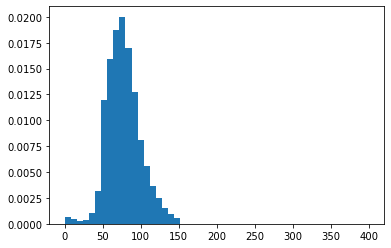

In [5]:
times = data
statics = name_lis.drop(columns=['stay'])
statics["seq_len"]=np.array(seq_len)
name_lis = name_lis["stay"].values.tolist()
print(dynamics.columns)
print(statics.columns)

plt.hist(seq_len, range=(0,400), bins=50, density=True)
plt.show()

In [6]:
from general.missingprocessor import Processor
dynamics_types = ["categorical" if str(x) in cat_name else "continuous" for x in dynamics.columns]
dynamics_types[1] = 'binary'
#statics_types = ["binary", "continuous", "int"]
statics_types = ["binary", "int"]
dynamics_types[6] = 'int'

d_P = Processor(dynamics_types, use_pri='Hours')
s_P = Processor(statics_types)
d_P.fit(dynamics)
s = s_P.fit_transform(statics)

Hours 1 None continuous None
[48.] [0.]
Capillary refill rate 1 0.9977933650781616 binary 1.0
Diastolic blood pressure 1 0.29253768118900225 continuous 67.0
[375.] [0.]
Fraction inspired oxygen 1 0.9603396191203786 continuous 0.5
[1.1] [0.2]
Glascow coma scale eye opening 5 0.8049923748261373 categorical None
['1 No Response' 'None' 'Spontaneously' 'To Pain' 'To Speech']
Glascow coma scale motor response 6 0.8058649688140594 categorical Localizes Pain
['Abnormal Flexion' 'Abnormal extension' 'Flex-withdraws' 'Localizes Pain'
 'No response' 'Obeys Commands']
Glascow coma scale total 1 0.8846040012480209 int 3.0
[15.] [3.]
Glascow coma scale verbal response 5 0.8056878256736543 categorical No Response
['Confused' 'Inappropriate Words' 'Incomprehensible sounds' 'No Response'
 'Oriented']
Glucose 1 0.8229450666728874 continuous 189.0
[2200.] [0.]
Heart Rate 1 0.2856188929355607 continuous 81.0
[6632.] [0.]
all values are integer
Height 1 0.9975790437477948 int 173.0
[275.] [0.]
Mean blood 

In [7]:
d_lis=[d_P.transform(ds) for ds in times]
d = [x[0].tolist() for x in d_lis]
lag = [x[1].tolist() for x in d_lis]
mask = [x[2].tolist() for x in d_lis]
times = [x[-1].tolist() for x in d_lis]
priv = [x[3].tolist() for x in d_lis]
nex = [x[4].tolist() for x in d_lis]
label = [float(x[-2]) for x in s]
from fastNLP import DataSet
dataset = DataSet({"seq_len": seq_len, 
                   "dyn": d, "lag":lag, "mask": mask,
                   "sta": s, "times":times, "priv":priv, "nex": nex, "label": label
                  })
dic = {
    "train_set": dataset,
    "dynamic_processor": d_P,
    "static_processor":s_P,
    "name_lis": name_lis
}
from utils.general import make_sure_path_exists
make_sure_path_exists("./data/inhospital/")
with open("./data/inhospital/fullhos.pkl", "wb") as f:
    pickle.dump(dic, f)